In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.contrib.concurrent import process_map
from constants import HAZARD_P, SLIP_P, GOAL, HAZARD

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

<Axes: xlabel='teacher', ylabel='pred_res'>

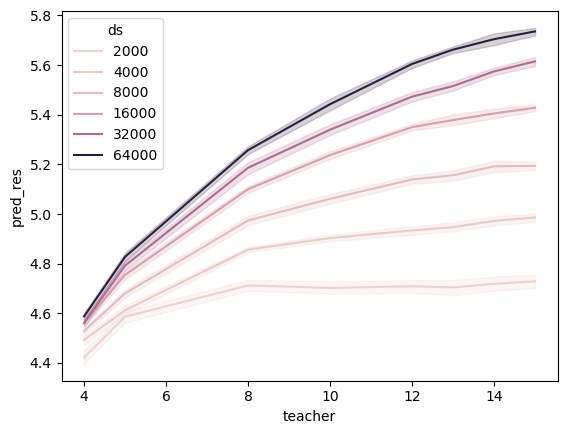

In [16]:
names = ['student','teacher','map_size','ds','node','true_res','pred_res','eval_acc']
df = pd.read_csv('output/3_eval_models.txt', names=names)
df = df[df.node==1024]
sns.lineplot(data=df[df.student==3],x='teacher',hue='ds',y='pred_res')

In [ ]:
# names = ['map_size','student', 'Teacher', 'Train_Size', 'test', 'seed', 'Reward']
# df = pd.read_csv('output/res_curr.txt', names=names)
# print(df.shape)
# df2 = df[(df.map_size==12)].groupby(['student']).Reward.mean().reset_index()
# df2 = df[(df.map_size==12) & (df.student==0)]
# df2.loc[:,'student'] = df2['student'].astype(str)
# df2.loc[:,'Train_Size'] = df2['Train_Size'].astype(str)
# ax = sns.lineplot(data=df2, x='Teacher', y='Reward', hue='Train_Size', errorbar='se')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
import os
from constants import DIR

for student in range(2,16):
    for teacher in range(student, 16):
        for ds in [2000, 4000, 8000, 16000, 32000, 64000]:
            for seed in range(20):
                path = f'{DIR}/models_{4}_{256}_{6}/{student}_{teacher}_{ds}_{seed}.keras'
                if not os.path.isfile(path):
                    print(path)

In [ ]:
from _3_eval_models import reward_eval

In [ ]:
%%time
ts = 100
dense = 4
DIR = f'/storage1/fs1/chien-ju.ho/Active/gym/{HAZARD_P}_{SLIP_P}_{GOAL}_{HAZARD}_{1}'
node = 1024

res = []
for node in [256, 1024]:
    for map_size in [6]:
        for student in range(1,11):
            for teacher in range(student+1,16):
                iterables = []
                for ds in [2000, 4000, 8000, 16000, 32000, 64000]:
                    for seed in range(20):
                        iterables.append([map_size, student, teacher, ds, DIR, dense, node, ts, seed])
                print(f'{node} {student} {teacher}')
                res.extend(process_map(reward_eval, *zip(*iterables), chunksize=1, max_workers=10, leave=False))
res = np.array(res).mean(axis=2)

In [ ]:
res.shape

In [ ]:
iterables2 = []
for node in [256, 1024]:
    for map_size in [6]:
        for student in range(1):
            for teacher in range(student+1,16):
                for ds in [2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000, 1024000, 2048000, 4096000]:
                    for seed in range(1):
                        iterables2.append([map_size, student, teacher, ds, DIR, dense, node, ts, seed])

In [ ]:
df1 = pd.DataFrame(iterables2, columns=['map_size','student','teacher','ds','dir','dense','node','ts', 'seed'])
df1 = df1[['student','teacher','map_size','ds','node']]
df2 = pd.DataFrame(res, columns=['true_res','pred_res','acc'])
df = pd.concat([df1, df2], axis=1)

In [ ]:
df[(df.student==0) & (df.ds==4096000)]

In [ ]:
sns.lineplot(data=df[df.student==2],x='teacher',hue='ds',y='pred_res')

In [ ]:
with open('/storage1/fs1/chien-ju.ho/Active/gym/test.txt', 'w') as f:
    for i in range(1000):
        print(f'writing line {i}', file=f, flush=True)

In [ ]:
print(' Teacher     Data 1.0     Model 1.0     Model Acc')
for teacher, (at, ap, aa) in zip(teachers, res):
    print(f'{teacher:>8}     {np.mean(at): 8.4f}      {np.mean(ap): 8.4f}      {np.mean(aa): 8.4f}')


In [ ]:
print(' Teacher     Data 1.0     Model 1.0     Model Acc')
for teacher, (at, ap, aa) in zip(teachers, res):
    print(f'{teacher:>8}     {np.mean(at): 8.4f}      {np.mean(ap): 8.4f}      {np.mean(aa): 8.4f}')


In [ ]:
# 2 million test
print('Teacher     Data 1.0     Model 1.0     Model Acc')
for teacher, (at, ap, aa) in zip(teachers, res):
    print(f'     {teacher:>2}     {np.mean(at): 8.4f}      {np.mean(ap): 8.4f}      {np.mean(aa): 8.4f}')


In [ ]:
# 1 million test
print('Teacher     Data 1.0     Model 1.0     Model Acc')
for teacher, (at, ap, aa) in zip(teachers, res):
    print(f'     {teacher:>2}     {np.mean(at): 8.4f}      {np.mean(ap): 8.4f}      {np.mean(aa): 8.4f}')


In [ ]:
DIR

In [ ]:
DIR = '/storage1/fs1/chien-ju.ho/Active/gym/0_0_10_-1_1'

map_size = 8
skip = map_size**2
test_size = 1000 * skip

teacher = 12

x, y = [], []
for test_group in range(test_size//3000+1):
    data = np.load(f'{DIR}/data{map_size}/test/myopic_{teacher}_{test_group}.npz')
    x.append(data['x'])   
    y.append(data['y'])
x = np.concatenate(x)
y = np.concatenate(y)


In [ ]:
x.shape

In [ ]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

model = tf.keras.models.load_model(f'{DIR}/models{map_size}/{0}_{teacher}_{1024000}_{0}.keras')

In [ ]:
y_pred = model(x[:100])
(y_pred.numpy().argmax(axis=1) == y[:100])

In [ ]:
y_pred[1]

In [ ]:
y[1]

In [ ]:
x[1][1]

In [ ]:
x[1][0]+x[1][3]